In [38]:
import os
from concurrent.futures import ProcessPoolExecutor
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import utils, Sequential

from utils import err
from repository.insurance_premium_estimation_repository import (_simple_insurance_premium_prediction, generate_random_insurance_data,
                                                                LockType, FrameMaterial, BikeType, WK_DEVICE_VERSIONS,
                                                                MIN_PRICE, MAX_PRICE, MIN_LOCK_PRICE, MAX_LOCK_PRICE, MAX_SECONDS_IN_MONTH)
from repository.insurance_premium_estimation_repository import prepare_insurance_data as prepare_data

SAVES_PATH_RELATIVE = 'checkpoints/'
SAVES_PATH = os.path.join(os.path.dirname(SAVES_PATH_RELATIVE), SAVES_PATH_RELATIVE)
BATCH_SIZE = 64
DATA_COUNT = 150000


tf.config.experimental.set_virtual_device_configuration(
    tf.config.experimental.list_physical_devices('GPU')[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]
)

def generate_dataset(size: int) -> tuple[np.array, np.array]:
    return tuple(zip(*(
        (i.as_list_of_values, _simple_insurance_premium_prediction(i)) for i in (generate_random_insurance_data() for _ in range(size))
    )))


In [39]:
data_x, data_y = generate_dataset(DATA_COUNT)

print(data_x[:5])
print(data_y[:5])

([3998.51, 1, 4, 4, 759464, 0.0, 0.1036903220320869, 0.07327565636407388, 0.1025943271750889, 0.0, 26622, 3.72, 2, True, True], [1203.11, 3, 4, 2, 1193710, 0.0, 0.058075496075321226, 0.5423340439481279, 0.6005881728929882, 0.0, 39014, 15.94, 3, False, True], [1361.63, 2, 5, 2, 1870813, 0.0, 0.03887411897827053, 0.28144378929029557, 0.4800314609242823, 0.017433017596025027, 61655, 29.68, 3, False, True], [3193.53, 1, 5, 2, 1074653, 0.09852811624768809, 0.1343145764841964, 0.30745430763557197, 0.26211073461958456, 0.09740077873215822, 34917, 12.56, 3, True, False], [3715.75, 3, 0, 2, 984677, 0.0, 0.0, 0.05869715095007888, 0.20551452552026447, 0.00264905556311253, 33244, 40.6, 3, True, True])
(48.93, 12.7, 21.96, 30.25, 34.9)


In [40]:
data_x_prepared, data_y_prepared = prepare_data(data_x, data_y)
x_size = len(data_x_prepared[0])

print(data_x_prepared[:5])
print(data_y_prepared[:5])
print()
print(data_x_prepared.shape)
print(data_y_prepared.shape)

[[3.93788889e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 2.83551374e-01 0.00000000e+00
  1.03690322e-01 7.32756564e-02 1.02594327e-01 0.00000000e+00
  9.93951613e-03 7.22166499e-04 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.11425253e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.45680257e-01 0.00000000e+00
  5.80754961e-02 5.42334044e-01 6.00588173e-01 0.00000000e+00
  1.45661589e-02 1.29789368e-02 0.000

In [41]:
# def get_inner():
#     x = Input((x_size * 8, ))
#     x_in = x
#     x = Dense(x_size * 16, activation="leaky_relu")(x)
#     tf.keras.layers.Dropout(0.1),
#     x = Dense(x_size * 8, activation="leaky_relu")(x)
#     y = Dense(x_size * 8, activation="leaky_relu")(x_in)
#     y = tf.keras.layers.Add()([x, y])
#     y = tf.keras.activations.relu(y)
#     return tf.keras.models.Model(inputs = x_in, outputs = y)

# inner_model1 = get_inner()

# model = Sequential([
#     Input((x_size, )),
#     Dense(x_size * 16, activation="leaky_relu"),
#     tf.keras.layers.Dropout(0.1),
#     Dense(x_size * 8, activation="leaky_relu"),
#     inner_model1,
#     Dense(x_size * 8, activation="leaky_relu"),
#     get_inner(),
#     tf.keras.layers.Dropout(0.1),
#     Dense(x_size * 4, activation="leaky_relu"),
#     Dense(1, activation="leaky_relu")
# ])
model = Sequential([
    Input((x_size, )),
    Dense(x_size * 4, activation="leaky_relu"),
    Dense(x_size * 8, activation="leaky_relu"),
    Dense(x_size * 16, activation="leaky_relu"),
    tf.keras.layers.Dropout(0.1),
    Dense(x_size * 8, activation="leaky_relu"),
    Dense(x_size * 4, activation="leaky_relu"),
    Dense(1, activation="leaky_relu")
])

model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0008),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[err]
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 136)               4760      
                                                                 
 dense_67 (Dense)            (None, 272)               37264     
                                                                 
 dense_68 (Dense)            (None, 544)               148512    
                                                                 
 dropout_24 (Dropout)        (None, 544)               0         
                                                                 
 dense_69 (Dense)            (None, 272)               148240    
                                                                 
 dense_70 (Dense)            (None, 136)               37128     
                                                                 
 dense_71 (Dense)            (None, 1)                

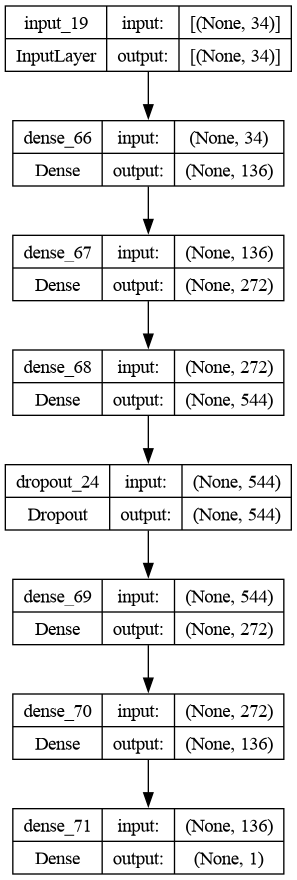

In [42]:
model.summary()
utils.plot_model(model, show_shapes=True)

In [43]:
# inner_model1.summary()
# utils.plot_model(inner_model1, show_shapes=True)

In [44]:
history = model.fit(
    data_x_prepared,
    data_y_prepared,
    epochs=64,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            SAVES_PATH + "checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5",
            monitor='val_loss',
            save_weights_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_err', min_delta=0.0001, patience=10, verbose=1
        )
    ],
    verbose=True,
    validation_split=0.2
)
model.save_weights(SAVES_PATH + "result.hdf5")

Epoch 1/64
1875/1875 [==============================] - 8s 3ms/step - loss: 28.5086 - err: 2.6369 - val_loss: 7.2374 - val_err: 1.2668
Epoch 2/64
1875/1875 [==============================] - 6s 3ms/step - loss: 8.0730 - err: 1.5136 - val_loss: 7.0173 - val_err: 1.2384
Epoch 3/64
1875/1875 [==============================] - 6s 3ms/step - loss: 6.5107 - err: 1.3393 - val_loss: 4.3777 - val_err: 1.0086
Epoch 4/64
1875/1875 [==============================] - 7s 4ms/step - loss: 5.5993 - err: 1.2093 - val_loss: 5.7700 - val_err: 1.5275
Epoch 5/64
1875/1875 [==============================] - 7s 4ms/step - loss: 4.7851 - err: 1.1107 - val_loss: 3.6960 - val_err: 0.8261
Epoch 6/64
1875/1875 [==============================] - 6s 3ms/step - loss: 4.1939 - err: 1.0170 - val_loss: 3.7432 - val_err: 0.7156
Epoch 7/64
1875/1875 [==============================] - 6s 3ms/step - loss: 3.8767 - err: 0.9750 - val_loss: 2.4793 - val_err: 0.7848
Epoch 8/64
1875/1875 [==============================] - 6s 3m

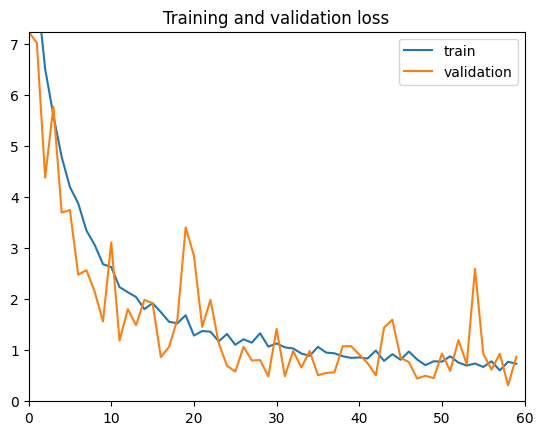

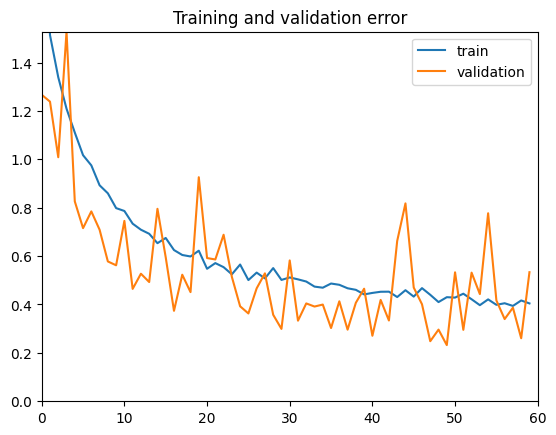

In [47]:
from matplotlib import pyplot as plt

loss = history.history['loss']
plt.figure()
plt.axis((0, len(loss), 0.0, max(history.history['val_loss'])))
plt.plot(range(len(loss)), history.history['loss'], label="train")
plt.plot(range(len(loss)), history.history['val_loss'], label="validation")
plt.title('Training and validation loss')
plt.legend()

err = history.history['err']
plt.figure()
plt.axis((0, len(err), 0.0, max(history.history['val_err'])))
plt.plot(range(len(err)), history.history['err'], label="train")
plt.plot(range(len(err)), history.history['val_err'], label="validation")
plt.title('Training and validation error')
plt.legend()


In [94]:
import json

raw_test_x, raw_test_y = generate_dataset(10)
test_x, test_y = prepare_data(raw_test_x, raw_test_y)

# model.load_weights(SAVES_PATH + "result.hdf5")
# print("Test data:\n" + json.dumps(raw_test_x, indent=4), '\n')
# print()
# print("Correct values: ", test_y, '\n')
# pred = np.array([round(i[0], 2) for i in model.predict(test_x)])
# print("Predicted values: ", pred, '\n')
# print("Error: ", round(np.average(np.abs(pred - test_y)), 2))
# print()

# model.load_weights(SAVES_PATH + "checkpoint-38-0.7340.hdf5")
model = tf.keras.models.load_model('result-0.4537.keras', custom_objects={'err': err})
print()
print("Correct values: ", test_y, '\n')
pred = np.array([round(i[0], 2) for i in model.predict(test_x)])
print("Predicted values: ", pred, '\n')
print("Error: ", round(np.average(np.abs(pred - test_y)), 2))
print()


Correct values:  [ 36.6   24.92  14.69   0.    12.53   0.   107.9   15.07  20.51  12.  ] 

1/1 [==============================] - 0s 50ms/step
Predicted values:  [ 3.6330e+01  2.4680e+01  1.4550e+01 -6.0000e-02  1.2500e+01 -0.0000e+00
  1.0793e+02  1.5140e+01  2.0230e+01  1.2420e+01] 

Error:  0.15



In [90]:
model.save(SAVES_PATH + "result-0.4537.keras")